# TimeSeries Udang Size 40

Notebook ini berisi tentang pembuatan model predict terhadap harga data udang yang jumlah udangnya berjumlah 40 dalam 1kg, Pemilihan Model Predict ini berdasarkan acuan metrics MAE dan MAPE 

# Library

In [1]:
# Libary untuk proses Data
import numpy as np
import pandas as pd
import pickle

# Library untuk Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose

# Library Model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Library Metriks
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [14]:
df_ori = pd.read_csv("shrimp_prices_week.csv")
df_ori

,date,size_30,size_40,size_50,size_60,size_70,size_80,size_100,province_id
0,2018-09-16,101000.000000,90000.000000,81000.000000,77000.000000,74000.000000,71000.000000,65000.000000,35.0
1,2018-09-23,100000.000000,88666.666667,80333.333333,76333.333333,73333.333333,70333.333333,64333.333333,35.0
2,2018-09-30,99000.000000,87333.333333,79666.666667,75666.666667,72666.666667,69666.666667,63666.666667,35.0
3,2018-10-07,98000.000000,86000.000000,79000.000000,75000.000000,72000.000000,69000.000000,63000.000000,35.0
4,2018-10-14,97000.000000,84666.666667,78333.333333,74333.333333,71333.333333,68333.333333,62333.333333,35.0
...,...,...,...,...,...,...,...,...,...
309,2024-08-18,80000.000000,75000.000000,68000.000000,65000.000000,62000.000000,60000.000000,53000.000000,35.0
310,2024-08-25,80000.000000,75000.000000,67514.150943,65000.000000,61028.301887,59028.301887,51509.915094,35.0
311,2024-09-01,83846.153846,76538.461538,69307.692308,65769.230769,62307.692308,59538.461538,53769.230769,35.0
312,2024-09-08,80000.000000,74000.000000,68000.000000,66000.000000,62000.000000,60000.000000,54000.000000,35.0


terdapat 314 baris dan 9 kolom 

# Data Cleaning

In [15]:
df_40 = df_ori[['date','size_40']]
df_40

,date,size_40
0,2018-09-16,90000.000000
1,2018-09-23,88666.666667
2,2018-09-30,87333.333333
3,2018-10-07,86000.000000
4,2018-10-14,84666.666667
...,...,...
309,2024-08-18,75000.000000
310,2024-08-25,75000.000000
311,2024-09-01,76538.461538
312,2024-09-08,74000.000000


Pengurangan jumlah kolom yang digunakan menjadi hanya 1 yaitu kolom harga udang size 40 saja

In [18]:
df_40 =df_40.rename(columns={"date":"Week"})


merubah nama kolom date menjadi week

In [19]:
df_40['Week'] = pd.to_datetime(df_40['Week'])
df_40.set_index('Week',inplace=True)
df_40.head()

,size_40
Week,
2018-09-16,90000.000000
2018-09-23,88666.666667
2018-09-30,87333.333333
2018-10-07,86000.000000
2018-10-14,84666.666667


merubah kolom week menjadi index

# EDA

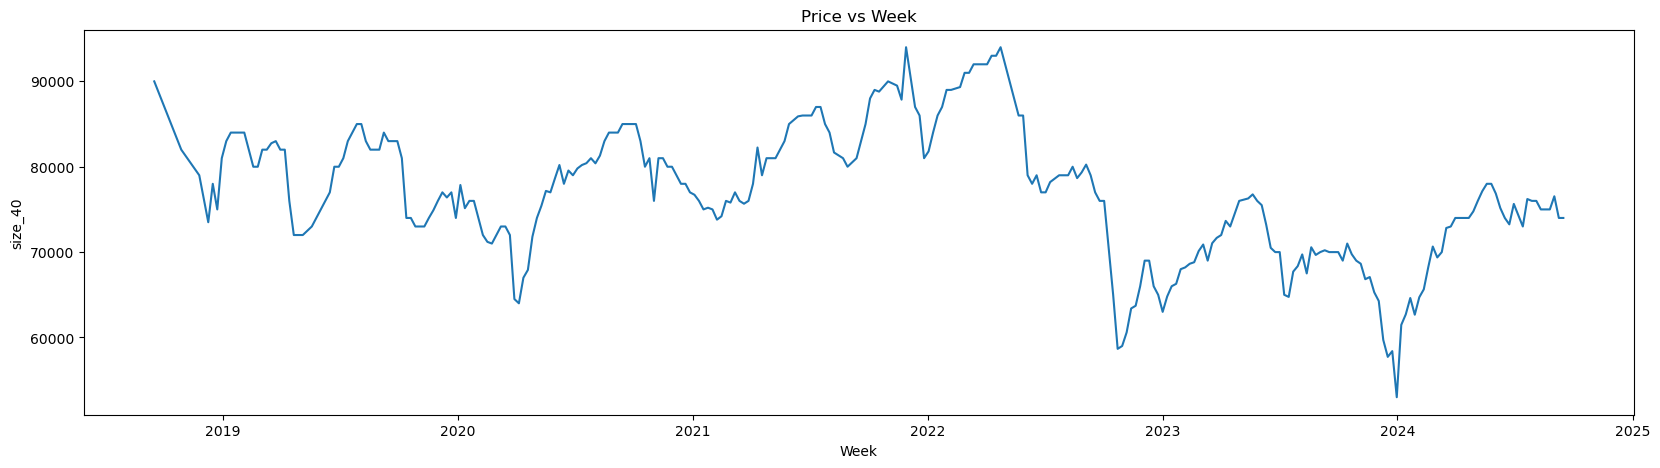

In [21]:
# Visualisasi data
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df_40.index ,y = 'size_40',data = df_40)
plt.title('Price vs Week');

Grafik Harga Udang size 40 pertahun mulai dari pertengahan tahun 2018 hingga pertengahan tahun 2024 dilihat dari grafik pertahun harga udang mengalami penurunan dan mengalami harga paling rendah di awal tahun 2024 

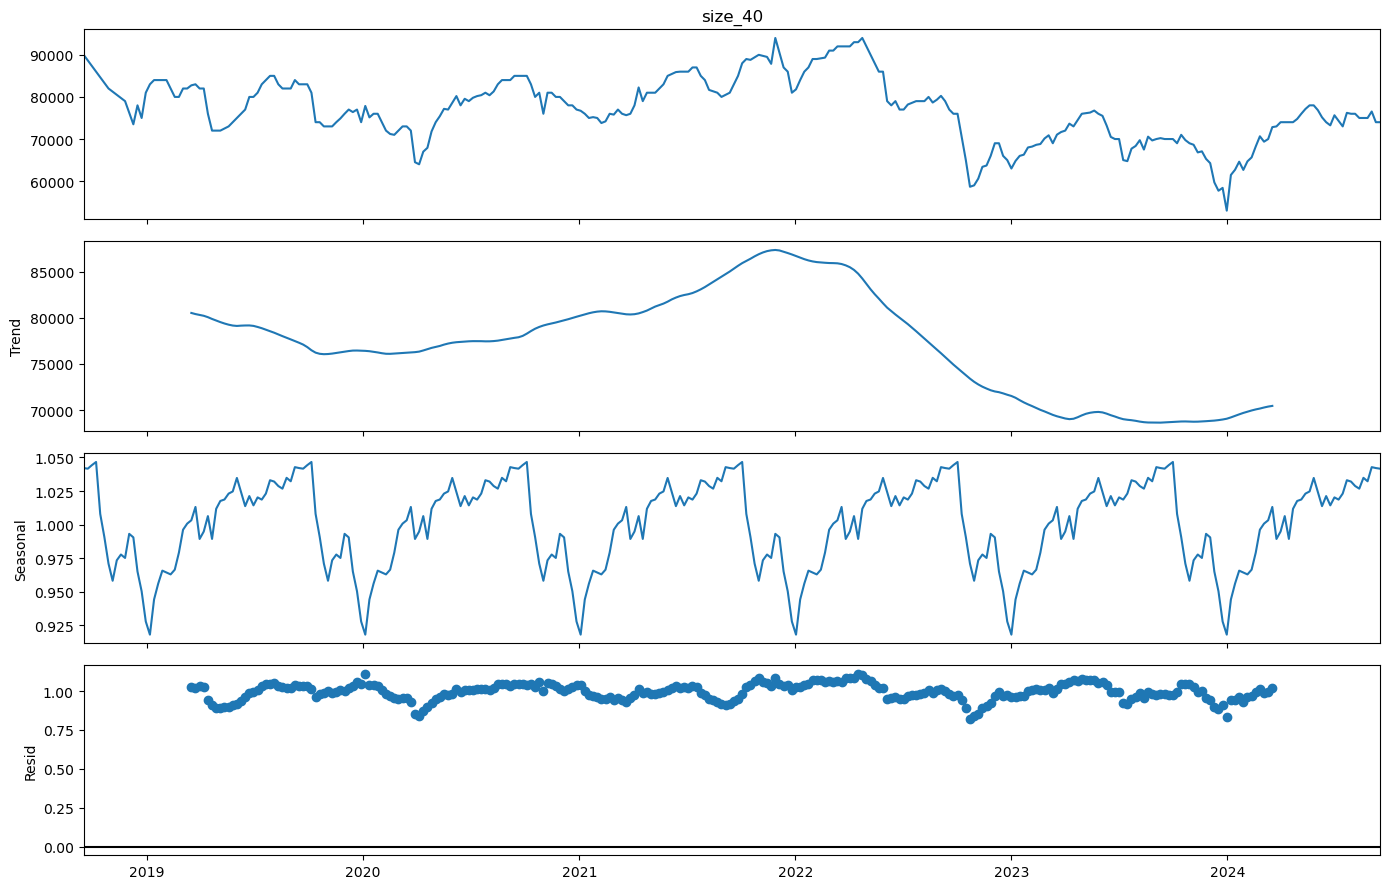

In [22]:
# Dekomposisi timeseries

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_40['size_40'], model='multiplicatif')
ax=res.plot()
plt.show()

In [25]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [26]:
# Proses check stationarity
check_stationarity(df_40['size_40'])

ADF Statistic: -3.129812
p-value: 0.024424
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Stationary


Data sudah stationary maka  tidak diperlukan differencing

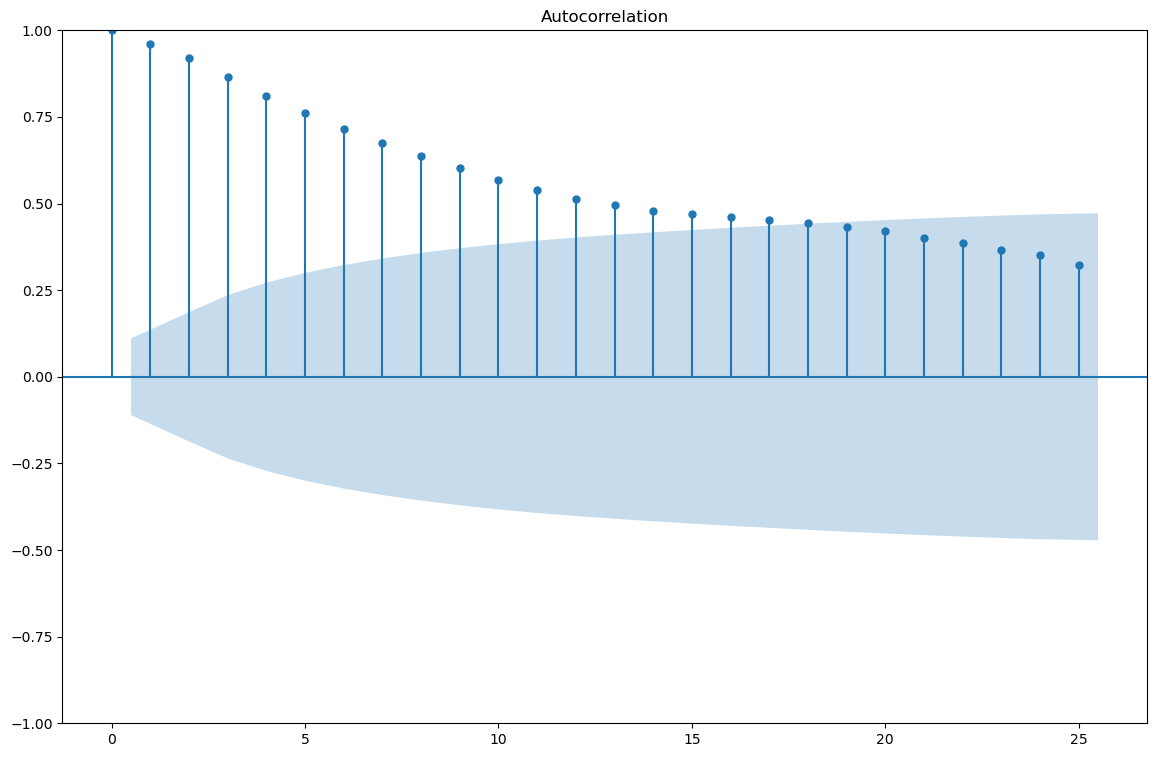

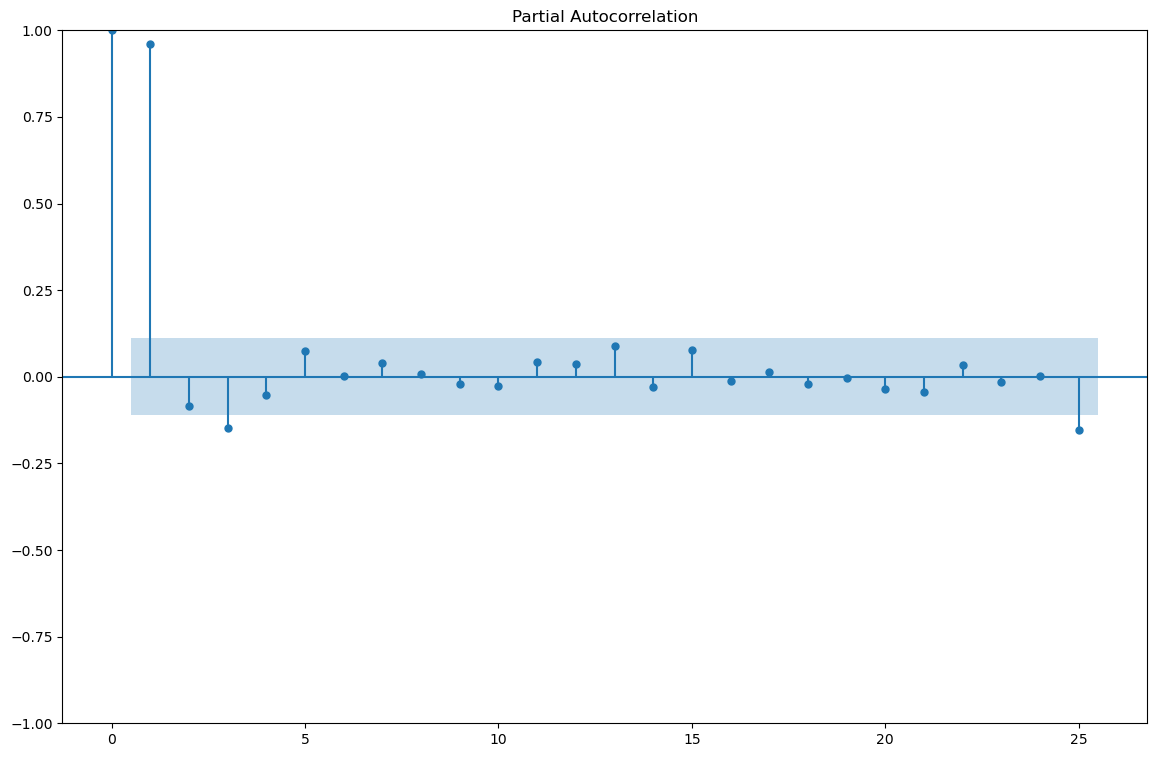

In [27]:
plot_acf(df_40['size_40'])
plot_pacf(df_40['size_40'])
plt.show()

P= 3 D =0 Q = 15 berdasarkan visualisasi acf dan pacf

# Modeling

In [29]:
model_arima_visual = ARIMA(df_40['size_40'], order=(3, 0, 15))
result_model_arima_visual = model_arima_visual.fit()

print('The AIC is ', result_model_arima_visual.aic)

The AIC is  5665.490398027648


aic yang didapat dengan menggunakan P = 3 D = 0 Q = 15 adalah 5665.49

In [28]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[1]
  df['d'] = pdq[2]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

pembuatan fungsi pencarian best model

In [9]:
# Find best model of ARIMA with combinations of p=1, d=1, q=1

find_best_model(df_40['size_40'], 1, 1, 1)

(1,
 0,
 0,
 5636.295271505038,
    p  d  q          AIC
 2  1  0  0  5636.295272
 7  1  1  1  5637.105106
 3  1  1  1  5638.292511
 6  1  0  0  5638.295957
 5  0  1  1  5655.737528
 4  0  0  0  5656.207699
 1  0  1  1  6174.981816
 0  0  0  0  7996.739872)

pencarian best model menggunakan fungsi dengan combinasi p= 1 d =1 q= 1 didapat aic paling kecil di 5636 dengan menggunakan p= 1 d =0 =q 0

In [30]:
train = df_40[:250]
test = df_40[250:]
print(f"Train Size : {train.shape}")
print(f"Test Size : {test.shape}")

Train Size : (250, 1)
Test Size : (64, 1)


jumlah data dibagi menjadi train sebanyak 250 dan test sebanyak 64

In [31]:
# Menggunakan parameter PDQ dari plot visual

model_arima_visual = ARIMA(train['size_40'], order=(3,0,15))
result_model_arima_visual = model_arima_visual.fit()

print("AIC ARIMA Visual :",result_model_arima_visual.aic)

AIC ARIMA Visual : 4504.377268979932


hasil aic train sebesar 4504

In [32]:
arima_pred_test_viz = result_model_arima_visual.predict(start="2023-07-02", end="2024-09-15",dynamic=True)
arima_pred_test_viz = pd.DataFrame(arima_pred_test_viz)
arima_pred_test_viz.columns = ['price_predict_vizplot']

In [33]:
# Concate dengan actual test set
act_vs_pred_sar = pd.concat([test, arima_pred_test_viz],axis=1)
act_vs_pred_sar

,size_40,price_predict_vizplot
2023-07-02,70000.000000,69441.790401
2023-07-09,65000.000000,69813.711046
2023-07-16,64750.000000,70387.709737
2023-07-23,67714.285714,70780.906696
2023-07-30,68357.142857,71378.046068
...,...,...
2024-08-18,75000.000000,78606.177908
2024-08-25,75000.000000,78623.817904
2024-09-01,76538.461538,78640.596363
2024-09-08,74000.000000,78656.555362


In [34]:
print('MAE test  : ', mean_absolute_error(test, arima_pred_test_viz))
print('RMSE test : ', np.sqrt(mean_squared_error(test, arima_pred_test_viz)))

MAE test  :  6357.017503004932
RMSE test :  8109.856373727404


Hasil MAE setelah dilakukan train dengan menggunakan  P = 3 D = 0 Q = 15 MAE sebesar 6357.01 dan RMSE 8109.85 artinya besar jumlah error harga dari data aktual dan data test sebesar 6357 ini relatif kecil dengan patokan harga per 1kg udangnya di kisaran 65000 hingga 75.000 rupiah

In [35]:
size = int(len(df_40) - 65)
train_v2, test_v2 = df_40['size_40'][0:size], df_40['size_40'][size:len(df_40)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train_v2]
predictions = []

for t in range(len(test_v2)):
    
    model = ARIMA(history, order=(3,0,15))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_v2[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 70499.552188, expected = 70000.000000
predicted = 69441.790401, expected = 70000.000000
predicted = 70434.158675, expected = 65000.000000
predicted = 64861.744078, expected = 64750.000000
predicted = 64108.918688, expected = 67714.285714
predicted = 68184.764119, expected = 68357.142857
predicted = 69936.148927, expected = 69727.272727
predicted = 70331.416798, expected = 67500.000000
predicted = 67788.959489, expected = 70566.037736
predicted = 71232.251173, expected = 69666.666667
predicted = 69661.856608, expected = 70000.000000
predicted = 70623.306908, expected = 70214.285714
predicted = 70844.470338, expected = 70000.000000
predicted = 70724.681703, expected = 70000.000000
predicted = 70691.573039, expected = 70000.000000
predicted = 70318.043303, expected = 69000.000000
predicted = 68825.620206, expected = 71000.000000
predicted = 71579.834284, expected = 69750.000000
predicted = 70248.518396, expected = 69000.000000
predicted

In [36]:
# Menghitung MAPE
mape = np.mean(np.abs((test_v2 - predictions) / test_v2)) * 100

print('MAPE test : ', mape)

MAPE test :  2.293524769401557


besar MAPE test 2.29 yang artinya percentage error harga dari prediksi dan actual hanya 2%

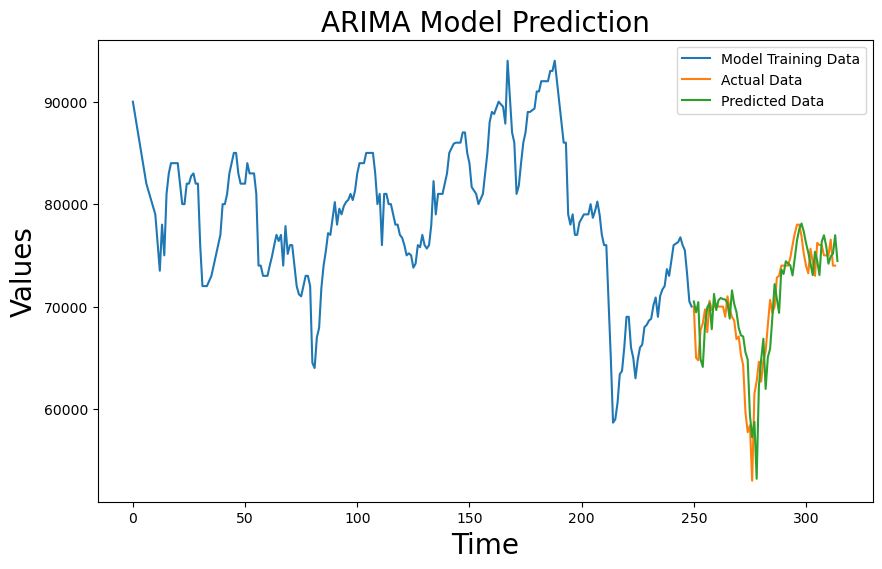

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot training data
plt.plot(range(len(train)), train, label='Model Training Data')

# Plot actual data (test set)
plt.plot(range(len(train), len(train) + len(test)), test, label='Actual Data')

# Plot predicted data
plt.plot(range(len(train), len(train) + len(predictions)), predictions, label='Predicted Data')

# Add labels and title
plt.xlabel('Time', size=20)
plt.ylabel('Values', size=20)
plt.title('ARIMA Model Prediction', size=20)
plt.legend()

# Show plot
plt.show()

visualiasi Harga udang size 40 yang dilakukan yang test pada data ke 250 hingga data ke 314 dari visualiasi cukup bagus karna harga prediksi tidak begitu jauh dengan harga aktual nya

# Model Saving

In [38]:
with open('model40.pkl','wb') as model40_file:
    pickle.dump(result_model_arima_visual, model40_file)

Saving Model arima

# SARIMA

In [39]:
# Splitting dataset

train_sar = df_40[:250]
test_sar = df_40[250:]

print('Train size : ', train_sar.shape)
print('Test size : ', test_sar.shape)

Train size :  (250, 1)
Test size :  (64, 1)


Pembagian data train dan data test

In [41]:

# Train using SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

sar=SARIMAX(train_sar['size_40'], order=(3,0,15),seasonal_order=(3,0,15, 27)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              size_40   No. Observations:                  250
Model:             SARIMAX(3, 0, 15)x(3, 0, 15, 27)   Log Likelihood               -2229.826
Date:                              Tue, 24 Sep 2024   AIC                           4533.652
Time:                                      16:10:22   BIC                           4663.946
Sample:                                  09-16-2018   HQIC                          4586.091
                                       - 06-25-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3163      2.128      0.149      0.882      -3.854       4.487
ar.L2          0.3915      1.894      0.207      0.836      -3.321       4.104
ar.L3          0.2920      1.870      0.156      0.876      -3.373       3.957
ma.L1          0.8202      2.130      0.385      0.700      -3.355       4.995
ma.L2          0.5511      2.043      0.270      0.787      -3.452       4.555
ma.L3          0.2077      0.555      0.374      0.708      -0.880       1.295
ma.L4         -0.0295      0.407     -0.073      0.942      -0.827       0.768
ma.L5         -0.1287      0.236     -0.545      0.586      -0.591       0.334
ma.L6         -0.1984      0.340     -0.584      0.559      -0.864       0.467
ma.L7         -0.1519      0.388     -0.391      0.695      -0.912       0.609
ma.L8         -0.0418      0.344     -0.122      0.903      -0.716       0.632
ma.L9          0.0073      0.167      0.043      0.965      -0.320       0.335
ma.L10        -0.0460      0.136     -0.338      0.736      -0.313       0.221
ma.L11        -0.0205      0.174     -0.118      0.906      -0.362       0.321
ma.L12        -0.1642      0.145     -1.131      0.258      -0.449       0.120
ma.L13        -0.1567      0.318     -0.492      0.623      -0.781       0.467
ma.L14        -0.1039      0.356     -0.292      0.771      -0.802       0.594
ma.L15        -0.0605      0.115     -0.528      0.597      -0.285       0.164
ar.S.L27      -0.1035    233.055     -0.000      1.000    -456.883     456.676
ar.S.L54      -0.0295    272.215     -0.000      1.000    -533.561     533.502
ar.S.L81       0.0391    193.229      0.000      1.000    -378.683     378.761
ma.S.L27      -0.0929    236.832     -0.000      1.000    -464.274     464.088
ma.S.L54      -0.1623    269.802     -0.001      1.000    -528.965     528.640
ma.S.L81      -0.1339    216.168     -0.001      1.000    -423.816     423.548
ma.S.L108     -0.0507     93.866     -0.001      1.000    -184.024     183.922
ma.S.L135      0.0577     61.588      0.001      0.999    -120.653     120.769
ma.S.L162      0.0107     54.073      0.000      1.000    -105.970     105.991
ma.S.L189     -0.0122     34.181     -0.000      1.000     -67.005      66.981
ma.S.L216      0.0362     55.022      0.001      0.999    -107.805     107.877
ma.S.L243      0.1198     37.940      0.003      0.997     -74.242      74.482
ma.S.L270     -0.0313    218.332     -0.000      1.000    -427.955     427.892
ma.S.L297     -0.0379    371.375     -0.000      1.000    -727.919     727.844
ma.S.L324     -0.0187    318.554  -5.86e-05      1.000    -624.374     624.336
ma.S.L351      0.0021    402.787   5.14e-06      1.000    -789.446     789.450
ma.S.L378      0.0308    331.192    9.3e-05      1.000    -649.094     649.155
ma.S.L405      0.0151    316.088   4.78e-05      1.000    -619.506     619.536
sigma2      3.289e+06      0.013  

AIC yang didapat setelah dilakukan modeling menggunakan sarimax didapat aic 4533

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict test-set
sar_pred_test = sar.predict(start="2023-07-02", end="2024-09-15", dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['size_40_predict']

# Reset index for alignment
test_sar_reset = test_sar['size_40'].reset_index(drop=True)
sar_pred_test_reset = sar_pred_test['size_40_predict'].reset_index(drop=True)

# Concatenate predictions with actual values
act_vs_pred_sar = pd.concat([test_sar_reset, sar_pred_test_reset], axis=1)

# Check the MAE & RMSE
mae_test = mean_absolute_error(test_sar_reset, sar_pred_test_reset)
rmse_test = np.sqrt(mean_squared_error(test_sar_reset, sar_pred_test_reset))

print('MAE test  : ', mae_test)
print('RMSE test : ', rmse_test)

# Display actual vs predicted
print(act_vs_pred_sar)


MAE test  :  3726.2727665880657
RMSE test :  5386.904581919629
         size_40  size_40_predict
0   70000.000000     69216.035327
1   65000.000000     70023.571464
2   64750.000000     70446.953026
3   67714.285714     70045.715986
4   68357.142857     69469.228275
..           ...              ...
59  75000.000000     74120.561766
60  75000.000000     73708.879233
61  76538.461538     74292.836741
62  74000.000000     73736.563337
63  74000.000000     73766.034347

[64 rows x 2 columns]


Hasil dari melatih model terhadap data test didapat MAE sebesar 3726 dan RMSE 5386

In [43]:
# Menghitung MAPE dengan menangani pembagian dengan nol
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Mengabaikan nilai aktual yang sama dengan nol untuk menghindari pembagian dengan nol
    non_zero_idx = y_true != 0
    y_true_non_zero = y_true[non_zero_idx]
    y_pred_non_zero = y_pred[non_zero_idx]
    
    # Hitung MAPE hanya pada data yang tidak memiliki nilai aktual nol
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

# Contoh penggunaan
mape_test = mean_absolute_percentage_error(test_sar_reset, sar_pred_test_reset)
print('MAPE test: ', mape_test)


MAPE test:  5.7254213274703


MAPE test data test dengan predict test sebesar 5.7%

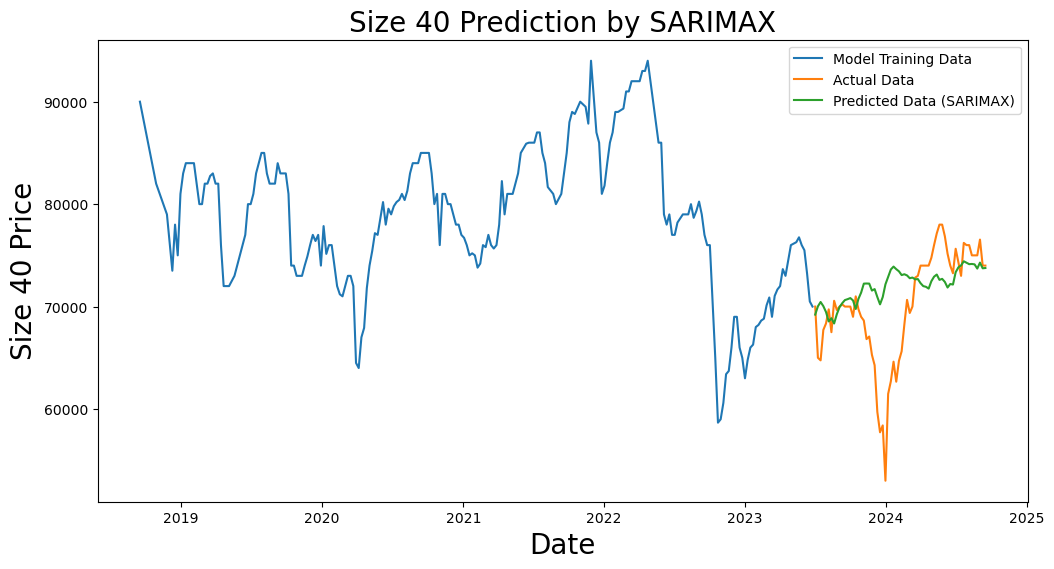

In [44]:
import matplotlib.pyplot as plt

# Plotting the SARIMAX model results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_sar['size_40'], label='Model Training Data')

# Plot actual test data
plt.plot(test_sar['size_40'].index, test_sar['size_40'], label='Actual Data')

# Plot predicted test data
plt.plot(test_sar['size_40'].index, sar_pred_test_reset, label='Predicted Data (SARIMAX)')

# Adding labels, title, and legend
plt.xlabel('Date', size=20)
plt.ylabel('Size 40 Price', size=20)
plt.title('Size 40 Prediction by SARIMAX', size=20)
plt.legend()

# Show plot
plt.show()


Visualisasi Grafik Harga udang size 40 pada yang dimulai pada pertengahan tahun 2023 hingga pertengahan tahun 2024.Dari visualisasi yang didapat Grafik prediksi harga menggunakan model sarima dan grafik data actual cukup berbeda secara signifikan dikarnakan MAE TEST yang tinggi dan juga MAPE Test yang tinggi membuat grafik cukup berbeda dibandingkan dengan menggunakan model arima


# Conclusion

Setelah dilakukan Uji Data test dengan penggunaan 2 model ARIMA dan SARIMA maka model yang akan dipilih untuk penggunaan aplikasi UJATIM adalah model ARIMA, ini dikarenakan berdasarkan MAE dan MAPE test yang didapat dengan menggunakan Model ARIMA cenderung lebih rendah dibandingkan dengan penggunaan model SARIMA